<a href="https://colab.research.google.com/github/r-scoville/deep-reinforcement-learning-lunar-lander/blob/main/lunar_lander_ppo_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning Agent (Lunar Lander)  
## Proximal Policy Optimization Model

---

November 2025  
R. Scoville  

### About  

This notebook creates, trains, and evaluates a deep reinforcement learning agent.  

Environment: Lunar Lander v2  
RL library: Stable-Baselines3  
Model: Proximal Policy Optimization

### References
*   [Hugging Face: Deep Reinforcement Learning Course, Unit 1](https://huggingface.co/learn/deep-rl-course/unit1/hands-on)
*   [Gymnasium Documentation: Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
*   [Stable-Baselines3 Documentation: Reliable Reinforcement Learning Implementations](https://stable-baselines3.readthedocs.io/en/master/)
*   [Stable-Baselines3 PPO Documentation](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)

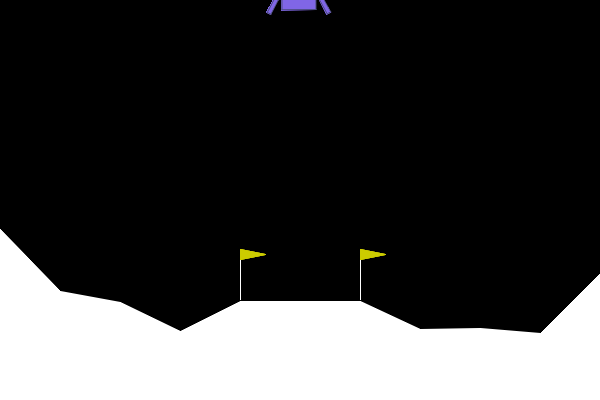

[[Image Source](https://gymnasium.farama.org/environments/box2d/lunar_lander)]

---
## 1. Set the GPU
This will accelerate the agent's training.  
`Runtime > Change runtime type > Hardware accelerator > T4 GPU`

---
## 2. Install dependences and create a virtual screen
*   `gymnasium[box2d]`: Contains the LunarLander-v2 environment  
*   `stable-baselines3[extra]`: The deep reinforcement learning library  
*   `huggingface_sb3`: Additional code for Stable-baselines3 to load and upload models from the Hugging Face Hub

In [ ]:
!apt install swig cmake

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,130 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 125082 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [ ]:
!pip install stable-baselines3==2.0.0a5
!pip install swig
!pip install gymnasium
!pip install box2d-py
!pip install huggingface_sb3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 23.9 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.2
    Uninstalling gymnasium-1.2.2:
      Successfully uninstalled gymnasium-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.28.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp312-cp312-linux_x86_64.whl size=2399053 sha256=7d7b9981bc3228fc95e4e1a38092c9df748e6db541b2fe7fea36575c4d00c94e
  Stored in directory: /root/.cache

During the notebook, we'll need to generate a replay video. To do so, with Colab, we need to have a virtual screen to be able to render the environment and record the frames.  

The following cell will install virtual screen libraries and create and run a virtual screen.

In [ ]:
!sudo apt-get update
!sudo apt-get install -y python3-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

To make sure the new installed libraries are used, sometimes it's required to restart the notebook runtime. The next cell will force the runtime to crash.Connect again and run the code starting from here. This enables the virtual screen to run.

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

---
## 3. Import the packages

One additional library to import is huggingface_hub. This is for uploading and downloading trained models from the hub.

The Hugging Face Hub works as a central place where anyone can share and explore models and datasets. It has versioning, metrics, visualizations and other features that allow for collaboration.

[See all deep RL models](https://huggingface.co/models?pipeline_tag=reinforcement-learning&sort=downloads)

In [ ]:
import gymnasium as gym

from huggingface_sb3 import load_from_hub, package_to_hub
from huggingface_hub import notebook_login # To log to my Hugging Face account to be able to upload models to the Hub.

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

---
## 4. Create the environment

[Gymnasium Lunar Lander documentation](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

Steps:  

1.   Create the environment using `gymnasium.make()`.
2.   Reset the environment to its initial state with `env.reset()`.
3.   See what the environment looks like.


In [ ]:
# Create the environment with gym.make("<name_of_the_environment>")
env = gym.make("LunarLander-v2")

# Reset the environment
env.reset()

### Observation Space Shape (8,)
The observation is a vector of size 8, where each value contains different information about the lander:

*   Horizontal pad coordinate (x)
*   Vertical pad coordinate (y)
*   Horizontal speed (x)  
*   Vertical speed (y)  
*   Angle  
*   Angular speed  
*   If the left leg contact point has touched the land (boolean)  
*   If the right leg contact point has touched the land (boolean)  

In [ ]:
# View the environment shape
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space Shape", env.observation_space.shape)

# Get a random observation
print("Sample observation", env.observation_space.sample())

### Action Space

The action space (the set of possible actions the agent can take) is discrete (finite) with 4 actions available:

- Action 0: Do nothing,
- Action 1: Fire left orientation engine,
- Action 2: Fire the main engine,
- Action 3: Fire right orientation engine.

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Take a random action

### Reward Function / Cumulative Reward

- **Reward function**: The function that will give a reward at each timestep

- **Cumulative reward**: After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- Is increased/decreased the closer/further the lander is to the landing pad.
- Is increased/decreased the slower/faster the lander is moving.
- Is decreased the more the lander is tilted (angle not horizontal).
- Is increased by 10 points for each leg that is in contact with the ground.
- Is decreased by 0.03 points each frame a side engine is firing.
- Is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.

### Vectorized Environment
This is a method for stacking multiple independent environments into a single environment. This allows more diverse experiences during the training.

In [ ]:
# Create a vectorized environment of 16 environments
env = make_vec_env('LunarLander-v2', n_envs=16)

---

## 5. Create the model

Library used: [Stable-Baseline3](https://stable-baselines3.readthedocs.io/en/master/)  
Model used: [SB3's PPO](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)

### About Proximal Policy Optimization (PPO)
Proximal Policy Optimization is a SOTA (state of the art) Deep Reinforcement Learning algorithm.  
PPO combines:

- Value-based reinforcement learning method:  
Learning an action-value function that will tell us the most valuable action to take given a state and action.

- Policy-based reinforcement learning method:  
Learning a policy that will give us a probability distribution over actions.

In [ ]:
# Define a PPO MlpPolicy architecture using MultiLayerPerceptron (MLPPolicy) because the input is a vector. If we had frames as input we would use CnnPolicy.

# Added parameters to accelerate training
model = PPO(
    policy = 'MlpPolicy',
    env = env,
    n_steps = 1024,
    batch_size = 64,
    n_epochs = 4,
    gamma = 0.999, # Discount rate – this gamma prioritizes long-term reward
    gae_lambda = 0.98,
    ent_coef = 0.01,
    verbose=1)

---
## 6. Train the PPO Model

Train the agent for 1,000,000 timesteps.  
Using GPU on Colab, it should take approximately ~20min.

In [ ]:
# Train it for 1,000,000 timesteps
model.learn(total_timesteps=1000000, progress_bar=True) # Added a progress bar

# Specify file name for model and save the model to file
model_name = "ppo-LunarLander-v2"
model.save(model_name)

---
## 7. Evaluate the agent
Wrap the environment in a Monitor.  
Check its performance using SB3's `evaluate_policy` method.  
When evaluating the agent, use an evaluation environment, not the training environment.

In [ ]:
# Evaluate the agent
# Create a new environment for evaluation
eval_env = Monitor(gym.make("LunarLander-v2", render_mode='rgb_array'))

# Evaluate the model with 10 evaluation episodes and deterministic=True
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)

# Print the results
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

---
## 8. Publish the agent to the Hugging Face Hub

Evaluate, record a replay, generate a model card of your agent, and push it to the hub using `package_to_hub`.

In [ ]:
# Copy and paste the Hugging Face authentication token
notebook_login()
!git config --global credential.helper store